In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

# Data Pipelines

In this exercise, you will practice pasting together multiple feature processing steps into a single pipeline that allows for easy cross-validation and model selection.

## Data

We will use the crime rate data that we have used in previous weeks. This time, we will not drop the first few columns or the rows with missing values in them.

In [3]:
from sklearn.model_selection import train_test_split

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
#          .iloc[:, 5:]
#          .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
X = crime[predictors]
y = crime[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
# train_df, test_df = train_test_split(crime, random_state=2)

Always start by taking a look at the first few rows of your data.

In [5]:
print X_train.shape
print X_test.shape
X_train.head()

(1495, 126)
(499, 126)


,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
55,79.0,17975.0,Cudahycity,10,0.01,0.36,0.01,0.97,0.04,0.04,...,NaN,0.01,0.33,0.26,NaN,NaN,NaN,NaN,0.0,NaN
35,NaN,NaN,Gallupcity,8,0.01,0.67,0.02,0.23,0.07,0.64,...,NaN,0.03,0.14,0.01,NaN,NaN,NaN,NaN,0.0,NaN
6,NaN,NaN,Petalumacity,1,0.05,0.46,0.02,0.88,0.20,0.17,...,NaN,0.03,0.29,0.24,NaN,NaN,NaN,NaN,0.0,NaN
13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,0.01,...,NaN,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.0,NaN
48,NaN,NaN,Templecity,8,0.06,0.38,0.33,0.59,0.05,0.25,...,NaN,0.12,0.09,0.01,NaN,NaN,NaN,NaN,0.0,NaN


## EDA

It's always a good idea to start by asking yourself a few questions about the data. For example
- What types of features are there?
- Are there missing values?
- What is the distribution of the target?

#### What types of features are there?

In [15]:
print X_train.dtypes.value_counts()
X_train.dtypes

float64    124
int64        1
object       1
dtype: int64


county                  float64
community               float64
communityname            object
fold                      int64
population              float64
householdsize           float64
racepctblack            float64
racePctWhite            float64
racePctAsian            float64
racePctHisp             float64
agePct12t21             float64
agePct12t29             float64
agePct16t24             float64
agePct65up              float64
numbUrban               float64
pctUrban                float64
medIncome               float64
pctWWage                float64
pctWFarmSelf            float64
pctWInvInc              float64
pctWSocSec              float64
pctWPubAsst             float64
pctWRetire              float64
medFamInc               float64
perCapInc               float64
whitePerCap             float64
blackPerCap             float64
indianPerCap            float64
AsianPerCap             float64
OtherPerCap             float64
                         ...   
PctBornS

#### Are there missing values?

In [13]:
X_train.apply(lambda col: col.isnull()).sum().sort_values(ascending = False).head()
X_train.apply(lambda col: col.isnull()).mean().sort_values(ascending = False).head()

PolicBudgPerPop      0.838127
PctPolicMinor        0.838127
LemasTotalReq        0.838127
LemasTotReqPerPop    0.838127
PolicReqPerOffic     0.838127
dtype: float64

#### What is the distribution of the target?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dee5350>]], dtype=object)

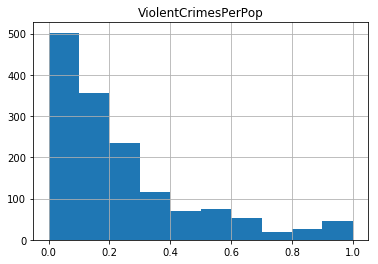

In [14]:
y_train.hist()

#### What are the distributions of the features?

It looks like there are both continuous and categorical features. It is usually a good idea to separate them.

In [22]:
categorical_predictors = ['county', 'community', 'fold', 'communityname']
numeric_predictors = X_train.columns[4:]

##### Numeric

In [23]:
# Gives good overview summary 
# Sometimes easier to look at it transposed (T)
X_train[numeric_predictors].describe().T

,count,mean,std,min,25%,50%,75%,max
population,1495.0,0.056883,0.122571,0.00,0.0100,0.020,0.0600,1.0
householdsize,1495.0,0.464074,0.165073,0.00,0.3500,0.440,0.5400,1.0
racepctblack,1495.0,0.177331,0.252775,0.00,0.0200,0.060,0.2200,1.0
racePctWhite,1495.0,0.752020,0.246175,0.00,0.6300,0.840,0.9400,1.0
racePctAsian,1495.0,0.153860,0.211290,0.00,0.0400,0.070,0.1600,1.0
racePctHisp,1495.0,0.150843,0.239894,0.00,0.0150,0.040,0.1650,1.0
agePct12t21,1495.0,0.423157,0.153432,0.00,0.3300,0.400,0.4800,1.0
agePct12t29,1495.0,0.493331,0.142199,0.00,0.4100,0.480,0.5400,1.0
agePct16t24,1495.0,0.335097,0.163870,0.00,0.2500,0.290,0.3600,1.0
agePct65up,1495.0,0.423880,0.179779,0.00,0.3000,0.420,0.5300,1.0


##### Categorical

In [24]:
for col in categorical_predictors:
    print col
    print X_train[col].value_counts().head()

county
3.0     58
17.0    48
9.0     34
1.0     31
7.0     28
Name: county, dtype: int64
community
21344.0    2
60120.0    2
57000.0    2
2060.0     2
51000.0    2
Name: community, dtype: int64
fold
6     155
4     155
5     154
1     153
10    152
Name: fold, dtype: int64
communityname
Jacksonvillecity    5
Greenvillecity      4
Athenscity          4
Columbuscity        3
Milfordtown         3
Name: communityname, dtype: int64


Both `community` and `communityname` look like they are sliced too thin to be useful. `fold` is probably an index that was added for k-fold cross-validation. So it looks like the only real categorical variable is `county`. We'll leave `communityname` for now, just so we have more than one categorical variable.

In [25]:
categorical_predictors = ['county', 'communityname']

## Processing

There are a few obvious things we would like to do with this data before we start trying different models.

1. Impute missing values. For categorical variables, this is easy, a good strategy is to just add a new level: '?'. For the continuous variables, we need to be a little bit more careful.
- All of our sklearn learning algorithms only work with numeric data. We need to convert the categorical column to numeric, using either one-hot encoding or feature hashing.
- Some learning algorithms are sensitive to scaling. We should try normalizing the numeric features.
- This dataset has a relatively large number of features, compared to a small number of examples. We might want to try some dimensionality reduction (will be discussed in future classes).

There are different strategies for the two feature types (numeric and categorical), so we will treat them individually.

## Numeric Feature Processing Pipeline

For the continuous features, there are two main feature processing steps:
1. Impute missing values
2. Scale features to normalized z-scores.

One can imagine other feature processing steps, e.g. dealing with outliers, discretization, etc., but we will stick with these for now

In [26]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer
from sklearn.pipeline import Pipeline

### Step 1: Select Numeric Features

In [29]:
X_train_numeric = X_train[numeric_predictors]
X_train_numeric.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
55,0.01,0.36,0.01,0.97,0.04,0.04,0.35,0.47,0.28,0.47,...,NaN,0.01,0.33,0.26,NaN,NaN,NaN,NaN,0.0,NaN
35,0.01,0.67,0.02,0.23,0.07,0.64,0.46,0.49,0.27,0.21,...,NaN,0.03,0.14,0.01,NaN,NaN,NaN,NaN,0.0,NaN
6,0.05,0.46,0.02,0.88,0.20,0.17,0.35,0.40,0.24,0.36,...,NaN,0.03,0.29,0.24,NaN,NaN,NaN,NaN,0.0,NaN
13,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,NaN,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.0,NaN
48,0.06,0.38,0.33,0.59,0.05,0.25,0.36,0.45,0.28,0.52,...,NaN,0.12,0.09,0.01,NaN,NaN,NaN,NaN,0.0,NaN


In [33]:
# define a function to select numeric predictors
def select_numeric_features(X):
    return X[numeric_predictors]

# Pass this function to the Function Transformer to complete transformation step
numeric_selector = FunctionTransformer(select_numeric_features, validate=False)
# creates and object (numeric_selector) to do fit and transform
# inherits all the functions that the scikit learn object has


In [34]:
X_train_numeric = numeric_selector.fit_transform(X_train)
X_train_numeric.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
55,0.01,0.36,0.01,0.97,0.04,0.04,0.35,0.47,0.28,0.47,...,NaN,0.01,0.33,0.26,NaN,NaN,NaN,NaN,0.0,NaN
35,0.01,0.67,0.02,0.23,0.07,0.64,0.46,0.49,0.27,0.21,...,NaN,0.03,0.14,0.01,NaN,NaN,NaN,NaN,0.0,NaN
6,0.05,0.46,0.02,0.88,0.20,0.17,0.35,0.40,0.24,0.36,...,NaN,0.03,0.29,0.24,NaN,NaN,NaN,NaN,0.0,NaN
13,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,NaN,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.0,NaN
48,0.06,0.38,0.33,0.59,0.05,0.25,0.36,0.45,0.28,0.52,...,NaN,0.12,0.09,0.01,NaN,NaN,NaN,NaN,0.0,NaN


### Step 2: Impute missing values

In [35]:
imp = Imputer(strategy='mean') #instansiate it
imp.fit(X_train_numeric) # fit the model with only the numeric features

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [41]:
X_train_imputed = imp.transform(X_train_numeric)
# X_train_imputed = imp.fit_transform(X_train_numeric)
X_train_imputed[:5,:10]

array([[ 0.01,  0.36,  0.01,  0.97,  0.04,  0.04,  0.35,  0.47,  0.28,
         0.47],
       [ 0.01,  0.67,  0.02,  0.23,  0.07,  0.64,  0.46,  0.49,  0.27,
         0.21],
       [ 0.05,  0.46,  0.02,  0.88,  0.2 ,  0.17,  0.35,  0.4 ,  0.24,
         0.36],
       [ 0.01,  0.36,  0.95,  0.24,  0.03,  0.01,  0.44,  0.42,  0.27,
         0.63],
       [ 0.06,  0.38,  0.33,  0.59,  0.05,  0.25,  0.36,  0.45,  0.28,
         0.52]])

In [42]:
X_test_imputed = imp.transform(numeric_selector.transform(X_test))
X_test_imputed[:5,:10]
# Make sure fit is ONLY run on TRAIN data so there is not leakage 

array([[ 0.02,  0.64,  0.02,  0.96,  0.05,  0.04,  0.39,  0.44,  0.25,
         0.18],
       [ 0.04,  0.55,  0.24,  0.74,  0.13,  0.12,  0.51,  0.48,  0.29,
         0.19],
       [ 0.03,  0.32,  0.01,  0.89,  0.31,  0.09,  0.28,  0.37,  0.2 ,
         0.38],
       [ 0.02,  0.32,  0.  ,  0.88,  0.06,  0.16,  0.36,  0.4 ,  0.26,
         0.57],
       [ 0.06,  0.43,  0.07,  0.78,  0.62,  0.08,  0.31,  0.52,  0.3 ,
         0.27]])

### Step 3: Scale

In [43]:
# cannot work on categorical fetaures or with df with missing values
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_imputed)
X_test_scaled = ss.transform(imp.transform(numeric_selector.transform(X_test)))
# Must happen in order

In [45]:
X_train_scaled[:5,:10]

array([[-0.3826247 , -0.63067988, -0.66219722,  0.88576311, -0.53905874,
        -0.46220389, -0.47696431, -0.16412824, -0.33633705,  0.25662557],
       [-0.3826247 ,  1.24790223, -0.62262315, -2.12123249, -0.39702617,
         2.0397386 ,  0.24020476, -0.02343345, -0.39738159, -1.19008012],
       [-0.05617361, -0.02468565, -0.62262315,  0.52004743,  0.21844831,
         0.07988365, -0.47696431, -0.65656002, -0.58051522, -0.35544223],
       [-0.3826247 , -0.63067988,  3.057765  , -2.08059741, -0.58640293,
        -0.58730102,  0.10981038, -0.51586522, -0.39738159,  1.14690599],
       [ 0.02543917, -0.50948103,  0.6041729 , -0.65836977, -0.49171455,
         0.41347598, -0.41176713, -0.30482303, -0.33633705,  0.5348382 ]])

### Put it all in a pipeline

In [47]:
# only input is a listof the steps you would like carried out in the order to carry it out
numeric_feature_pipeline = Pipeline(steps =[
    ('select', numeric_selector),
    ('impute', imp),
    ('sclae', ss)
])

# all of these have a transform and a fit method so they can work like puzzel pieces that work together. 
# this just establishes a processing pipeline - nothing more
# This has not used any data! 

In [48]:
# to fit the model now just use the pipeline
X_test_scaled = numeric_feature_pipeline.fit_transform(X_train)

In [49]:
X_test_scaled[:5,:10] # creates dataset that is the same as what we did above

array([[-0.3826247 , -0.63067988, -0.66219722,  0.88576311, -0.53905874,
        -0.46220389, -0.47696431, -0.16412824, -0.33633705,  0.25662557],
       [-0.3826247 ,  1.24790223, -0.62262315, -2.12123249, -0.39702617,
         2.0397386 ,  0.24020476, -0.02343345, -0.39738159, -1.19008012],
       [-0.05617361, -0.02468565, -0.62262315,  0.52004743,  0.21844831,
         0.07988365, -0.47696431, -0.65656002, -0.58051522, -0.35544223],
       [-0.3826247 , -0.63067988,  3.057765  , -2.08059741, -0.58640293,
        -0.58730102,  0.10981038, -0.51586522, -0.39738159,  1.14690599],
       [ 0.02543917, -0.50948103,  0.6041729 , -0.65836977, -0.49171455,
         0.41347598, -0.41176713, -0.30482303, -0.33633705,  0.5348382 ]])

## Categorical Feature Processing Pipeline

In [50]:
X_train[categorical_predictors].head()

,county,communityname
55,79.0,Cudahycity
35,NaN,Gallupcity
6,NaN,Petalumacity
13,NaN,Waycrosscity
48,NaN,Templecity


### Step 1: Select columns that correspond to categorical features

In [ ]:
# fix colums so they have the correct datatype (i.e. county = 79 is not a float)
# encode these features as categorical 

In [51]:
# Select the categorical features 
# define a function to select categorical features
def select_categorical_features(X):
    return X[categorical_predictors]

# Pass this function to the Function Transformer to complete transformation step
scf = FunctionTransformer(select_categorical_features, validate=False)

In [52]:
scf.fit_transform(X_train).head()

,county,communityname
55,79.0,Cudahycity
35,NaN,Gallupcity
6,NaN,Petalumacity
13,NaN,Waycrosscity
48,NaN,Templecity


#### Start a Pipeline

In [53]:
categorical_pipeline = Pipeline(steps = [
    ('select',scf)
])

In [54]:
categorical_pipeline.fit_transform(X_train).head()

,county,communityname
55,79.0,Cudahycity
35,NaN,Gallupcity
6,NaN,Petalumacity
13,NaN,Waycrosscity
48,NaN,Templecity


### Step 2: Ensure that each feature has the correct data type

In [55]:
# Datatype comversion function
# build a function that takes a dataframe and returns a datafram with dtype = str
def ensure_datatype(X):
    return X.apply(lambda col: col.astype(str))

ed = FunctionTransformer(ensure_datatype, validate=False)

#### Continue the pipeline

In [56]:
# Continue building on pipeline by added datatype conversion
categorical_pipeline = Pipeline(steps = [
    ('select',scf),
    ('datatype',ed)
])

In [58]:
categorical_pipeline.fit_transform(X_train).head()
# note: "nan" is not missing is is a string of letters nan

,county,communityname
55,79.0,Cudahycity
35,nan,Gallupcity
6,nan,Petalumacity
13,nan,Waycrosscity
48,nan,Templecity


### Step 3: Encode as numeric features

In [61]:
from sklearn.feature_extraction import DictVectorizer

# Creates a dictionary from data
# Creates an entry for each record
def make_dictionaries(X):
    return X.to_dict(orient='records')

md = FunctionTransformer(make_dictionaries, validate=False)

#### Continue the pipeline

In [65]:
# Continue building on pipeline by added datatype conversion
categorical_pipeline = Pipeline(steps = [
    ('select',scf),
    ('datatype',ed),
    ('dictionary',md),
    ('vectorize', DictVectorizer(sparse=False)) # prevents getting a sparse matrix
])

In [67]:
out = categorical_pipeline.fit_transform(X_train)
print out.shape
out[:5]

(1495, 1479)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [70]:
# you name your steps in your pipeline so you can access each step of the process as so
categorical_pipeline.get_params()['vectorize'].feature_names_[:10]
# shows we got a 1-hot encodeing 
# so we have one value for each possible "communityname" for each values

['communityname=Aberdeencity',
 'communityname=Aberdeentownship',
 'communityname=Adacity',
 'communityname=Aikencity',
 'communityname=Alabastercity',
 'communityname=Alamedacity',
 'communityname=Alamogordocity',
 'communityname=Albanycity',
 'communityname=Albemarlecity',
 'communityname=Albuquerquecity']

In [71]:
# this may give too many features and cause problems
# may want to pick another method

#### Let's do this with feature hashing instead

In [72]:
from sklearn.feature_extraction import FeatureHasher
categorical_pipeline = Pipeline(steps = [
    ('select',scf),
    ('datatype',ed),
    ('dictionary',md),
    ('vectorize', FeatureHasher(n_features=5)) # gives n buckets and assigns the fetaures to the buckets
])


In [77]:
X_train[categorical_predictors].head(10)

,county,communityname
55,79.0,Cudahycity
35,NaN,Gallupcity
6,NaN,Petalumacity
13,NaN,Waycrosscity
48,NaN,Templecity
48,NaN,LeagueCitycity
29,NaN,Kennettcity
54,NaN,Bluefieldcity
51,775.0,Salemcity
18,NaN,Connersvillecity


In [78]:
out = categorical_pipeline.fit_transform(X_train)
print out.shape
out.todense()[:10, :]

(1495, 5)


matrix([[ 0.,  1.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1., -1.],
        [ 0.,  1.,  0.,  0., -1.],
        [ 0.,  0.,  1.,  0., -1.],
        [ 0.,  0.,  0., -1., -1.],
        [ 0.,  1.,  0., -1.,  0.],
        [-1.,  0.,  0.,  0., -1.]])

## Combine the two Pipelines

In [81]:
# recap of code above: 
from sklearn.pipeline import FeatureUnion

## Function Defs
# Numeric 
def select_numeric_features(X):
    return X[numeric_predictors]
numeric_selector = FunctionTransformer(select_numeric_features, validate=False)
ss = StandardScaler()
imp = Imputer(strategy='mean')

# Categorical 
def select_categorical_features(X):
    return X[categorical_predictors]
scf = FunctionTransformer(select_categorical_features, validate=False)

def ensure_datatype(X):
    return X.apply(lambda col: col.astype(str))
ed = FunctionTransformer(ensure_datatype, validate=False)

def make_dictionaries(X):
    return X.to_dict(orient='records')
md = FunctionTransformer(make_dictionaries, validate=False)


# Pipelines
numeric_feature_pipeline = Pipeline(steps =[
    ('select', numeric_selector),
    ('impute', imp),
    ('sclae', ss)
])

categorical_pipeline = Pipeline(steps = [
    ('select',scf),
    ('datatype',ed),
    ('dictionary',md),
    ('vectorize', FeatureHasher(n_features=5)) # gives n buckets and assigns the fetaures to the buckets
])
# Above is the full code of what is needed to define a pipeline


# this Combines the two pipelines
fu = FeatureUnion([
    ('numeric', numeric_feature_pipeline),
    ('categorical', categorical_pipeline)
])

# if the pipeline changes, the results will changes
# for examples editing the fetuare haser feautres

In [82]:
out = fu.fit_transform(X_train)

In [85]:
test_out = fu.transform(X_test)

In [86]:
test_out.shape

(499, 127)

## Try some different models

The great thing about this paradigm is that you can write a whole data processing a modeling pipeline 'in the abstract' without doing anthing to your data. Scikit-learn then lets you treat the entire pipeline as one 'model', which allows you to do things like cross-validation and model selection without ever contaminating your test data.

### Linear Regression

Here is an example using linear regression

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

#### Define the Pipeline

In [91]:
# copied from above
# Pipelines
numeric_feature_pipeline = Pipeline(steps =[
    ('select', numeric_selector),
    ('impute', imp),
    ('sclae', ss)
])

categorical_pipeline = Pipeline(steps = [
    ('select',scf),
    ('datatype',ed),
    ('dictionary',md),
    ('vectorize', FeatureHasher(n_features=5)) # gives n buckets and assigns the fetaures to the buckets
])

# this Combines the two pipelines
fu = FeatureUnion([
    ('numeric', numeric_feature_pipeline),
    ('categorical', categorical_pipeline)
])

# Now, create a model pipe that that include preprocessing and the model fit 
model_pipe = Pipeline(steps=[
    ('preprocess',fu),
    ('model', LinearRegression())
])

In [93]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(steps=[('select', FunctionTransformer(accept_sparse=False,
          func=<function select_numeric_features at 0x10f8e6f50>,
          inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
         ...hts=None)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [94]:
model_pipe.score(X_test, y_test)

0.63765246784025464

#### Define some hyper-parameters to search over

In [105]:
# copied again
snf = FunctionTransformer(select_numeric_features, validate=False)
scf = FunctionTransformer(select_categorical_features, validate=False)
edt = FunctionTransformer(ensure_datatype, validate=False)
md = FunctionTransformer(make_dictionaries, validate=False)

model_pipe = Pipeline(steps=[
    ('preprocess', FeatureUnion([
        ('categorical', Pipeline([
           ('select',scf),
            ('datatype',edt),
            ('dictionary',md),
            ('vectorize', FeatureHasher()) 
        ])),
        ('numeric', Pipeline([
            ('select', snf),
            ('impute', Imputer()),
            ('sclae', StandardScaler())
        ]))
    ])),
    ('predict',Ridge())
])



In [106]:
search_params = {
    'preprocess__categorical__vectorize__n_features': [5,15,25,100],
    'preprocess__numeric__impute__strategy': ['mean','median'],
    'predict__alpha': [0.1, 1.0, 10.0]
}

#### Grid Search

In [107]:
grid_search = GridSearchCV(model_pipe, search_params, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('preprocess', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(steps=[('select', FunctionTransformer(accept_sparse=False,
          func=<function select_categorical_features at 0x10f8e6c80>,
          inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
 ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'preprocess__numeric__impute__strategy': ['mean', 'median'], 'preprocess__categorical__vectorize__n_features': [5, 15, 25, 100], 'predict__alpha': [0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

**Exercise**: Try to build your own pipeline. You can use a different estimator (e.g. Ridge(), RandomForestRegressor(), GradientBoostingRegressor(), SVR(), ...), and you can also add additional variables to the steps in the pipeline (e.g., what happens if you binarize the numeric variables? take the logs? perform dimensionality reduction with PCA?)

How high can you get your R^2 on the test set?